In [55]:
import urllib
from IPython.display import Markdown as md
import matplotlib.pylab as plt
import numpy as np

In [6]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.15.0
Found GPU at: /device:GPU:0


In [385]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Unique(y=<tf.Tensor: shape=(2,), dtype=uint8, numpy=array([1, 0], dtype=uint8)>, idx=<tf.Tensor: shape=(250000,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)

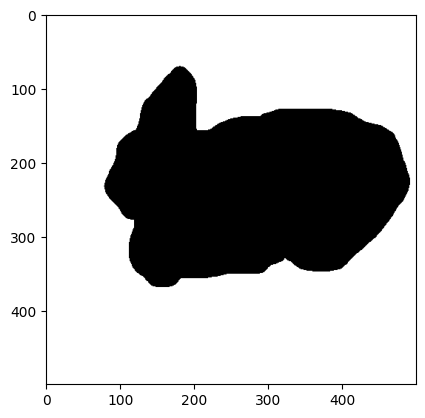

In [727]:
element=next(iter(dataset['train']))
mask=element['segmentation_mask']
plt.imshow(mask)
mask=mask-1
mask = tf.where(mask == 2, 0, mask)
plt.imshow(mask, cmap='gray')

maskf = tf.reshape(mask, [-1])

# Find the unique values using TensorFlow operations
uniquev= tf.unique(maskf)
uniquev

In [542]:
def read_and_preprocess(data):
  input_image = tf.image.resize(data['image'], (128, 128))
  input_image = tf.image.convert_image_dtype(input_image, tf.float32)
  input_mask= data['segmentation_mask']
  input_mask = tf.cast(input_mask, tf.float32)
  input_mask -= 1 # {1,2,3} to {0,1,2}
  input_mask = tf.where(input_mask == 2.0, 0.0, input_mask)
  input_mask = tf.image.resize(input_mask, (128, 128))
  input_mask = tf.where(input_mask > 0.5, 1.0, input_mask)
  input_mask = tf.where(input_mask < 0.5, 0.0, input_mask)
  
  return input_image, input_mask

In [543]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

In [544]:
img2,mask2=next(iter(train))
#plt.imshow(img2)
#plt.imshow(mask2)
mask2 = tf.reshape(mask2, [-1])

# Find the unique values using TensorFlow operations
uniquev= tf.unique(mask2)
uniquev = uniquev.y

print("Unique values:", uniquev.numpy())

Unique values: [1. 0.]


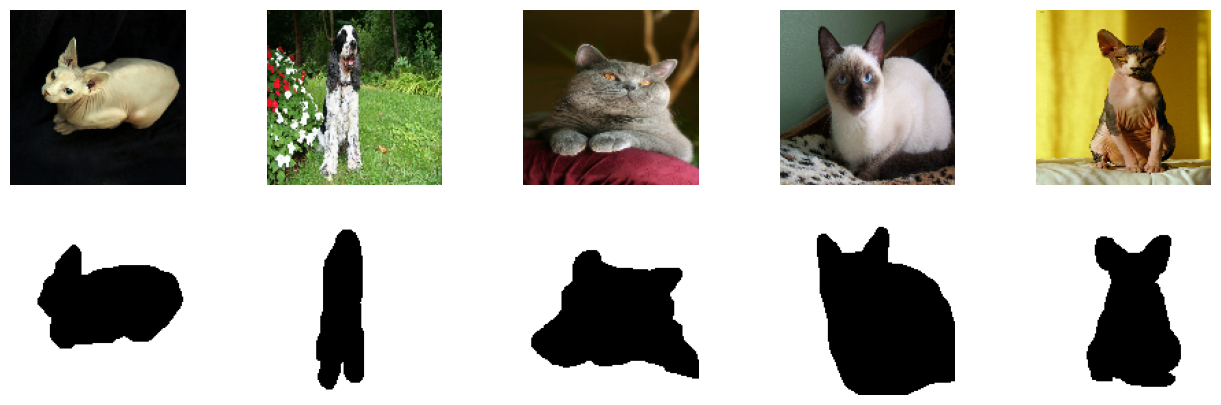

In [728]:
f, ax = plt.subplots(2, 5, figsize=(16,5))
for idx, (img, mask) in enumerate(train.take(5)):
  ax[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
  ax[0, idx].axis('off')
  #mask = tf.reshape(mask, [128, 128])
  ax[1, idx].imshow(mask.numpy(), cmap='gray')
  ax[1, idx].axis('off')

In [848]:
BATCH_SIZE = 200
BUFFER_SIZE = 1000

def augment(img, mask):
  if tf.random.uniform(()) > 0.5:
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
  return img, mask

train_dataset = train.cache().map(augment).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)

In [849]:
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS =1

In [688]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers to form skip connections
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,
                            name='pretrained_mobilenet')

down_stack.trainable = False

In [689]:
def upsample(filters, size, name):
  return tf.keras.Sequential([
     tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.ReLU()
  ], name=name)

up_stack = [
    upsample(512, 3, 'upsample_4x4_to_8x8'),
    upsample(256, 3, 'upsample_8x8_to_16x16'),
    upsample(128, 3, 'upsample_16x16_to_32x32'),
    upsample(64, 3,  'upsample_32x32_to_64x64')]

In [771]:
import re

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for idx, (up, skip) in enumerate(zip(up_stack, skips)):
    x = up(x)
    concat = tf.keras.layers.Concatenate(name='expand_{}'.format(idx))
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, padding='same', activation='sigmoid')
    
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [850]:
model = unet_model(OUTPUT_CHANNELS)

In [851]:
optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.9, beta_2=0.99,
                                     epsilon=1e-8)

In [852]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [789]:
# Assign to the pixel the label with the highest probability
def create_mask(pred_mask):
    pred_mask[pred_mask>0.5]=1
    pred_mask[pred_mask<0.5]=0
  #pred_mask = tf.argmax(pred_mask, axis=-1)
    #pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [790]:
# display helper functions
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
  
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray_r')
    
    plt.axis('off')
  plt.show()

def show_predictions(dataset, num):
  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)
    display([image[0], mask[0], create_mask(pred_mask)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


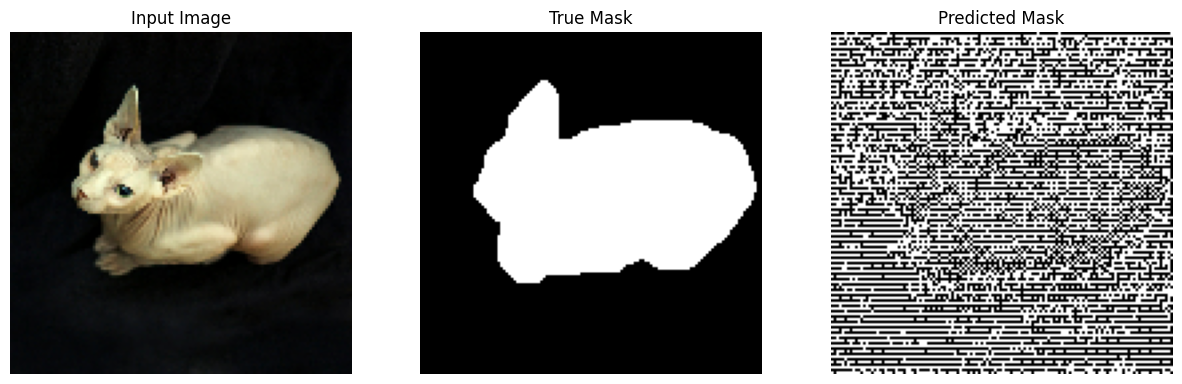

In [853]:
# before the model is trained
show_predictions(train.batch(1), 1)

In [784]:
# from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch%5 == 0:
      # clear_output(wait=True) # if you want replace the images each time, uncomment this
      show_predictions(train.batch(5), 1)
      print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/16


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step/step - accuracy: 0.5269 - loss: 0.856


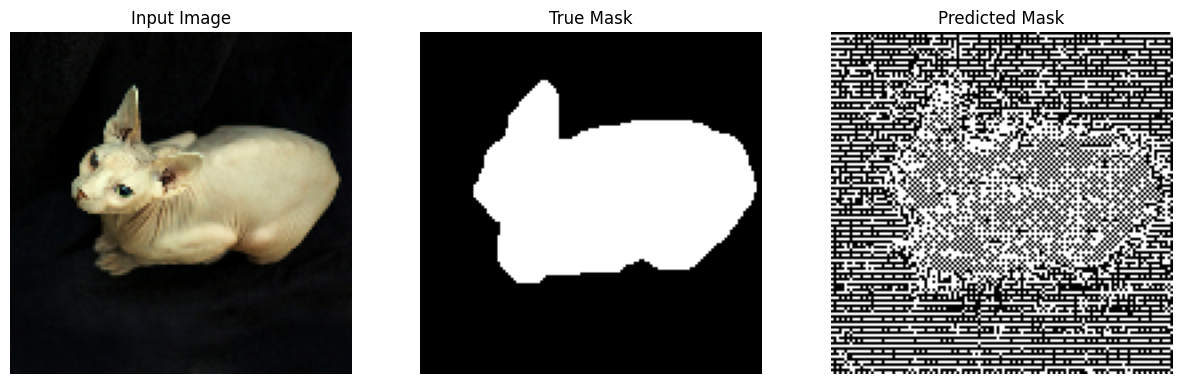


Sample Prediction after epoch 1

18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 727ms/step - accuracy: 0.5278 - loss: 0.8541 - val_accuracy: 0.5690 - val_loss: 0.7557
Epoch 2/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.6056 - loss: 0.6590 - val_accuracy: 0.6452 - val_loss: 0.6174
Epoch 3/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.7382 - loss: 0.5149 - val_accuracy: 0.7206 - val_loss: 0.5621
Epoch 4/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.8687 - loss: 0.4068 - val_accuracy: 0.7678 - val_loss: 0.5221
Epoch 5/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.9273 - loss: 0.3346 - val_accuracy: 0.7948 - val_loss: 0.4917
Epoch 6/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - accuracy: 0.9522 - loss: 0.285


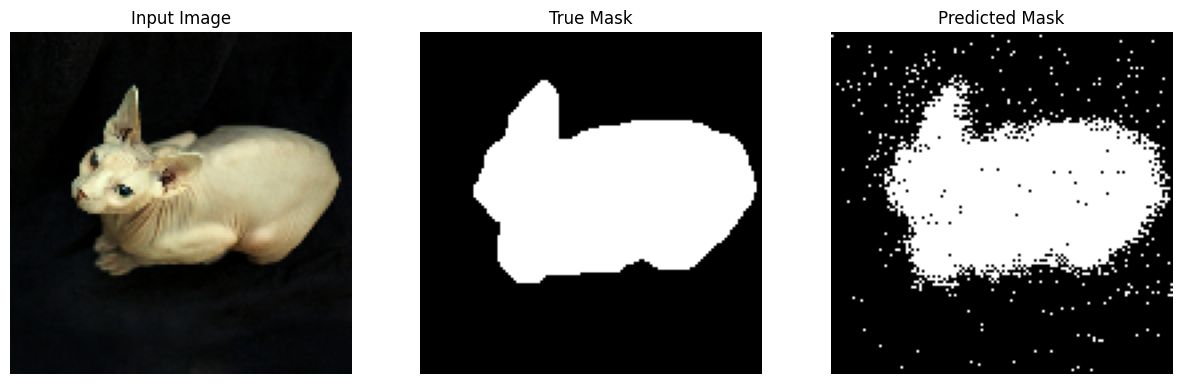


Sample Prediction after epoch 6

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.9524 - loss: 0.2850 - val_accuracy: 0.8100 - val_loss: 0.4681
Epoch 7/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - accuracy: 0.9631 - loss: 0.2497 - val_accuracy: 0.8304 - val_loss: 0.4345
Epoch 8/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.9700 - loss: 0.2211 - val_accuracy: 0.8204 - val_loss: 0.4444
Epoch 9/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9738 - loss: 0.1987 - val_accuracy: 0.8275 - val_loss: 0.4299
Epoch 10/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9757 - loss: 0.1812 - val_accuracy: 0.8236 - val_loss: 0.4344
Epoch 11/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/steptep - accuracy: 0.9784 - loss: 0.164


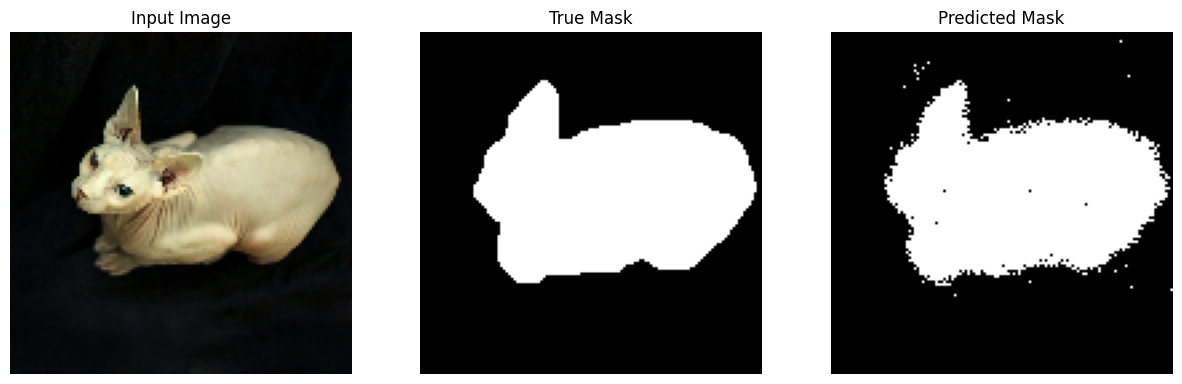


Sample Prediction after epoch 11

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - accuracy: 0.9784 - loss: 0.1640 - val_accuracy: 0.8247 - val_loss: 0.4329
Epoch 12/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9797 - loss: 0.1503 - val_accuracy: 0.8285 - val_loss: 0.4264
Epoch 13/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.9807 - loss: 0.1384 - val_accuracy: 0.8291 - val_loss: 0.4262
Epoch 14/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9816 - loss: 0.1275 - val_accuracy: 0.8423 - val_loss: 0.3983
Epoch 15/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.9824 - loss: 0.1179 - val_accuracy: 0.8289 - val_loss: 0.4302
Epoch 16/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/steptep - accuracy: 0.9831 - loss: 0.109


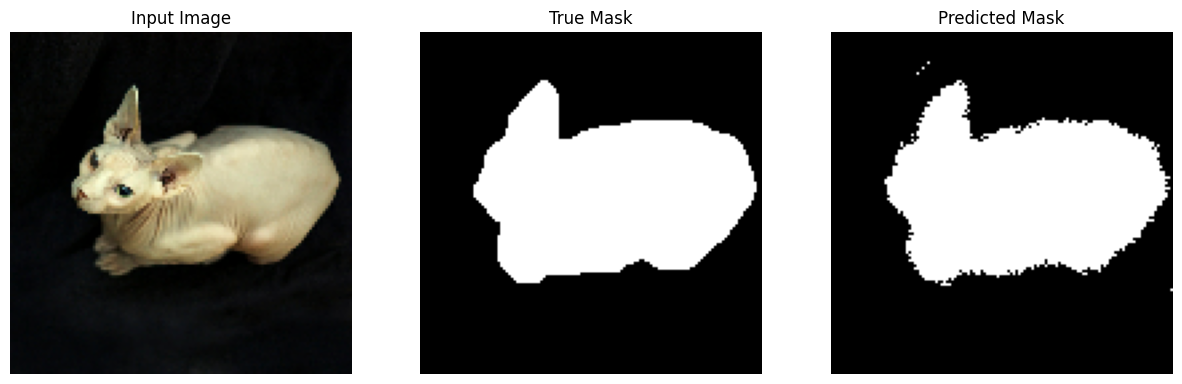


Sample Prediction after epoch 16

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9831 - loss: 0.1098 - val_accuracy: 0.8336 - val_loss: 0.4241


In [854]:
EPOCHS = 16
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


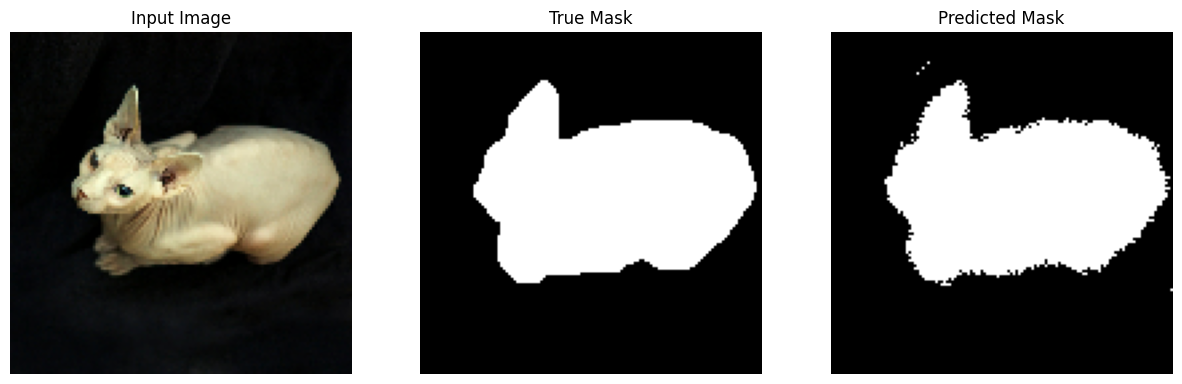

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


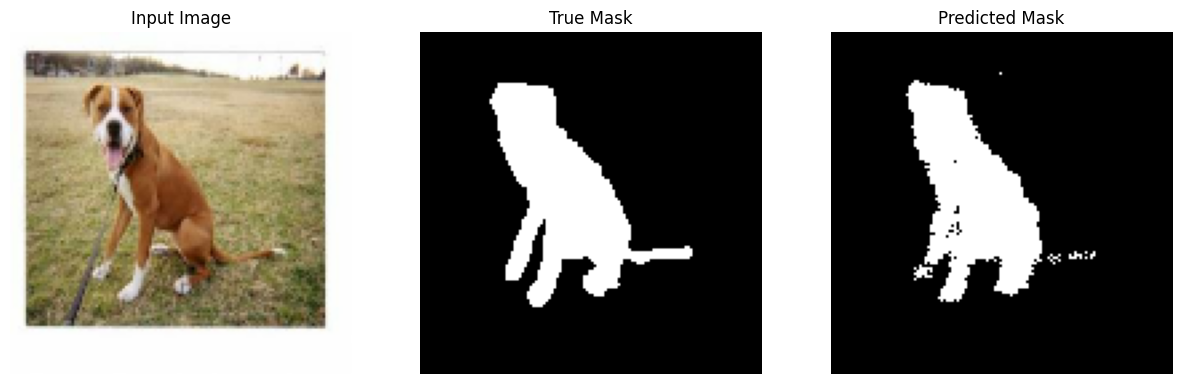

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


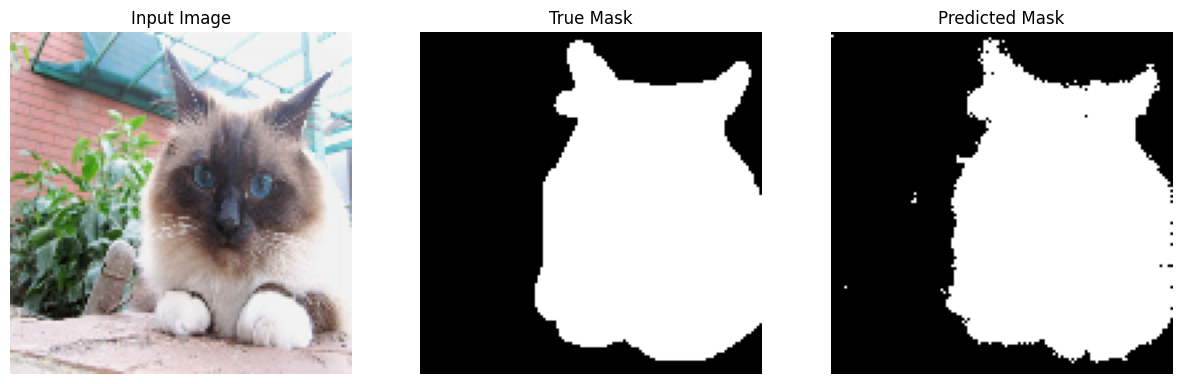

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


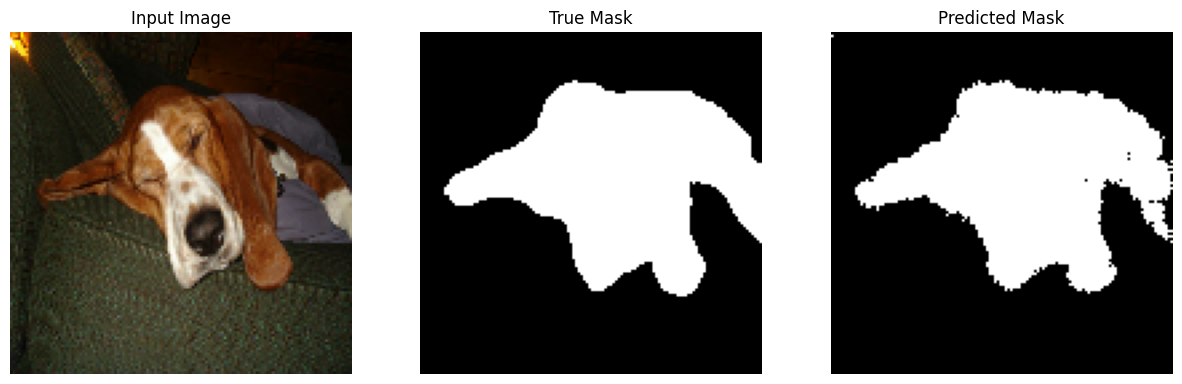

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


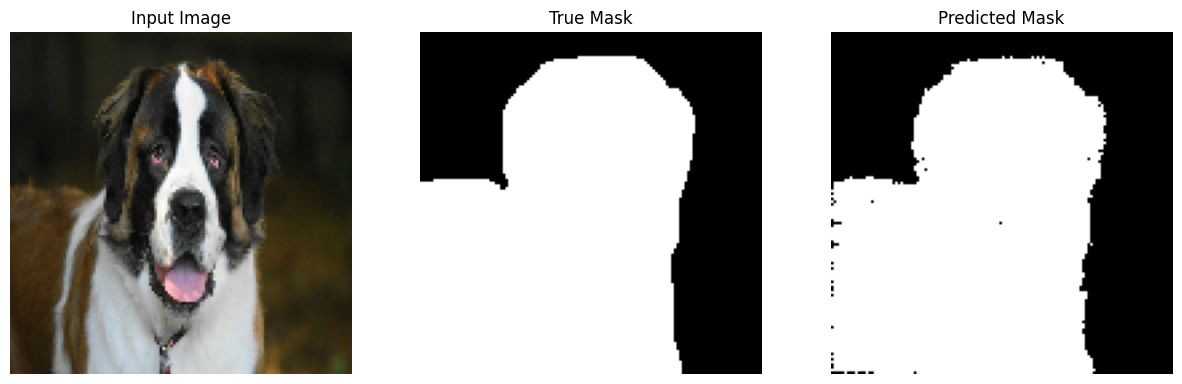

In [856]:
#one last time
show_predictions(train.batch(5), 5)

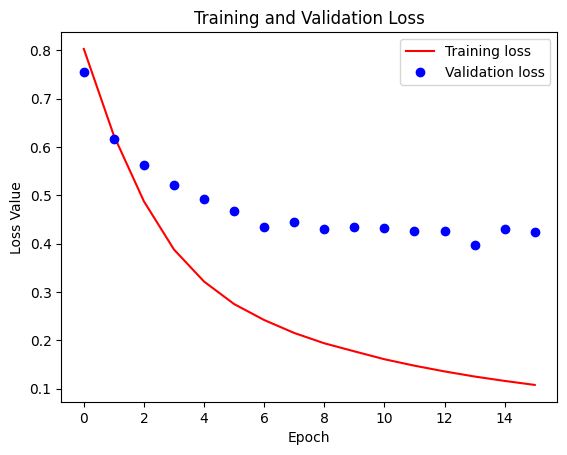

In [855]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

plt.legend()
plt.show()